## Snowpack Temperature Model (USGS Data)

This notebook implements a multi-layer 1D snowpack temperature model using **USGS NWIS data**.

**Data source:** Senator Beck and Ptarmigan meteorological stations via `usgs_collector.py`

**Key features:**
- **Heat conduction**: Between snow layers
- **Shortwave (SW) radiation**: Two-band absorption (VIS + NIR)
- **Longwave (LW) radiation**: Measured or parameterized
- **Turbulent fluxes**: Sensible and latent heat
- **Melt/refreeze**: Simple latent cooling clamp

**Validation**: Modeled surface temperature vs USGS non-contact surface temperature (`72405`)


In [13]:
import numpy as np
import math
from math import erf, sqrt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import ipywidgets as widgets
import datetime
import pandas as pd

# USGS Data Collector
from usgs_collector import fetch_usgs_iv, simplify_columns, STATIONS

## Constants and Parameters

Physical constants and model configuration. All units are SI.

In [14]:
# =============================================================================
# USGS DATA CONFIGURATION
# =============================================================================
STATION = "senator_beck"      # Options: "senator_beck", "ptarmigan"
START_DATE = "2026-01-01"     # Format: YYYY-MM-DD
END_DATE = "2026-01-31"       # 10-day window

# =============================================================================
# PHYSICAL CONSTANTS (SI Units)
# =============================================================================
sigma    = 5.67e-8          # Stefan-Boltzmann constant (W/m²/K⁴)
Lv_subl  = 2.83e6           # Latent heat of sublimation (J/kg)
z_ref    = 10               # Reference height for measurements (m)
Lf       = 3.34e5           # Latent heat of fusion (J/kg)
CH = 0.002                  # Sensible heat transfer coefficient
CE = 0.002                  # Latent heat transfer coefficient

# =============================================================================
# SNOWPACK PARAMETERS
# =============================================================================
N = 35                      # Number of layers
snow_depth_m = 1.5          # Total snow depth (m) - static for now
eps_snow   = 0.97           # Snow emissivity
c_snow = 2100.0             # Snow specific heat capacity (J/kg·K)
rho_snow = 200.0            # Snow density (kg/m³)
alpha_snow = 0.80           # Albedo of snow surface
k        = 0.2              # Snow thermal conductivity (W/m·K)

# =============================================================================
# AIR PARAMETERS (for ~3700m elevation)
# =============================================================================
rho_air = 0.84              # Air density (kg/m³)
c_pa     = 1005.0           # Specific heat of air (J/kg·K)
p_air = 65000               # Air pressure (Pa)

# =============================================================================
# MODEL OPTIONS
# =============================================================================
use_twoBand = True               # Two-band SW absorption
use_idealized_LWin = False       # Use measured LW (set True for parameterized)
use_idealized_SWout = False      # Use measured SW_out (set True for constant albedo)
show_plots = True                # Show diagnostic plots
generate_animation = False        # Generate temperature profile animation
n_days = 31                      # Simulation duration (days)
dt_max = 1800                    # Maximum timestep (seconds)
t_end = n_days * 24 * 3600       # End time (seconds)

## Load USGS Data

Fetch meteorological data directly from USGS NWIS API and create interpolators for the solver.

In [15]:
# =============================================================================
# FETCH USGS DATA
# =============================================================================
print(f"Fetching data for {STATION} from {START_DATE} to {END_DATE}...")

try:
    df_raw = fetch_usgs_iv(STATIONS[STATION], START_DATE, END_DATE)
    df = simplify_columns(df_raw)
except Exception as e:
    print(f"ERROR: Failed to fetch USGS data: {e}")
    print("Check your internet connection and station ID.")
    raise

if df.empty:
    raise ValueError("No data returned from USGS. Check date range and station availability.")

print(f"\nData shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Time range: {df.index[0]} to {df.index[-1]}")

# =============================================================================
# CHECK REQUIRED COLUMNS
# =============================================================================
required_cols = ['air_temp_c', 'rh_pct', 'wind_speed_mph', 
                 'sw_down_wm2', 'sw_up_wm2', 'lw_down_wm2', 'lw_up_wm2', 
                 'surface_temp_c']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"\n⚠️  MISSING REQUIRED COLUMNS: {missing_cols}")
    print("Available columns:", df.columns.tolist())
    raise ValueError(f"Missing required columns: {missing_cols}. Try a different date range.")
else:
    print("\n✓ All required columns present")

# =============================================================================
# CREATE TIME ARRAY (seconds since start)
# =============================================================================
times_sec = (df.index - df.index[0]).total_seconds().values
times_arr = times_sec / 3600.0  # Also keep hours for plotting

# =============================================================================
# BUILD INTERPOLATORS (All SI Units)
# =============================================================================
# Air temperature: Celsius → Kelvin
T_air_K = df['air_temp_c'].values + 273.15
T_air_interp = interp1d(times_sec, T_air_K, kind='linear', fill_value='extrapolate')

# For compatibility with existing code that expects Fahrenheit input
T_airF_interp = interp1d(times_sec, df['air_temp_c'].values * 9/5 + 32, kind='linear', fill_value='extrapolate')

# Relative humidity: percent (keep as-is for existing functions)
RH_arr_interp = interp1d(times_sec, df['rh_pct'].values, kind='linear', fill_value='extrapolate')

# Wind speed: mph → m/s
wind_ms = df['wind_speed_mph'].values * 0.44704
wind_interp = interp1d(times_sec, wind_ms, kind='linear', fill_value='extrapolate')

# Radiation: already in W/m²
SW_in_interp = interp1d(times_sec, df['sw_down_wm2'].values, kind='linear', fill_value='extrapolate')
SW_out_interp = interp1d(times_sec, df['sw_up_wm2'].values, kind='linear', fill_value='extrapolate')
LW_in_interp = interp1d(times_sec, df['lw_down_wm2'].values, kind='linear', fill_value='extrapolate')
LW_out_interp = interp1d(times_sec, df['lw_up_wm2'].values, kind='linear', fill_value='extrapolate')

# =============================================================================
# SURFACE TEMPERATURE INTERPOLATORS
# =============================================================================
# LW-derived surface temp (Stefan-Boltzmann inversion) - for comparison only
lw_derived_surf_K = (df['lw_up_wm2'].values / (eps_snow * sigma))**0.25
lw_derived_surf_C = lw_derived_surf_K - 273.15
surf_temp_obs_interp = interp1d(times_sec, lw_derived_surf_C, kind='linear', fill_value='extrapolate')

# USGS measured surface temperature (IR sensor, code 72405) - PRIMARY VALIDATION TARGET
usgs_surf_C = df['surface_temp_c'].values
usgs_temp_obs_interp = interp1d(times_sec, usgs_surf_C, kind='linear', fill_value='extrapolate')

print("\nInterpolators created successfully!")
print(f"Air temp range: {df['air_temp_c'].min():.1f}°C to {df['air_temp_c'].max():.1f}°C")
print(f"Surface temp (USGS): {usgs_surf_C.min():.1f}°C to {usgs_surf_C.max():.1f}°C")
print(f"Surface temp (LW-derived): {lw_derived_surf_C.min():.1f}°C to {lw_derived_surf_C.max():.1f}°C")


Fetching data for senator_beck from 2026-01-01 to 2026-01-31...
[USGS] Fetching site 375429107433201 from 2026-01-01 to 2026-01-31...
[USGS] Parameters: 00020, 00052, 00035, 00036, 00025, 72186, 72185, 72175, 72174, 72189, 72405, 72253, 72393, 72394, 61728
[USGS] Retrieved 740 records from 2026-01-01 00:00:00 to 2026-01-31 23:00:00

Data shape: (740, 16)
Columns: ['air_temp_c', 'pressure_mmhg', 'wind_speed_mph', 'wind_dir_deg', 'rh_pct', 'wind_gust_mph', 'lw_up_wm2', 'lw_down_wm2', 'sw_up_wm2', 'sw_down_wm2', 'snow_depth_m', 'soil_temp_c', 'soil_temp_c_2', 'lwc_pct', 'drifting_snow', 'surface_temp_c']
Time range: 2026-01-01 00:00:00 to 2026-01-31 23:00:00

✓ All required columns present

Interpolators created successfully!
Air temp range: -21.0°C to 1.0°C
Surface temp (USGS): -30.1°C to -2.2°C
Surface temp (LW-derived): -26.7°C to 0.2°C


## Plot Observed Data

Visualize the USGS data quality before running the model.

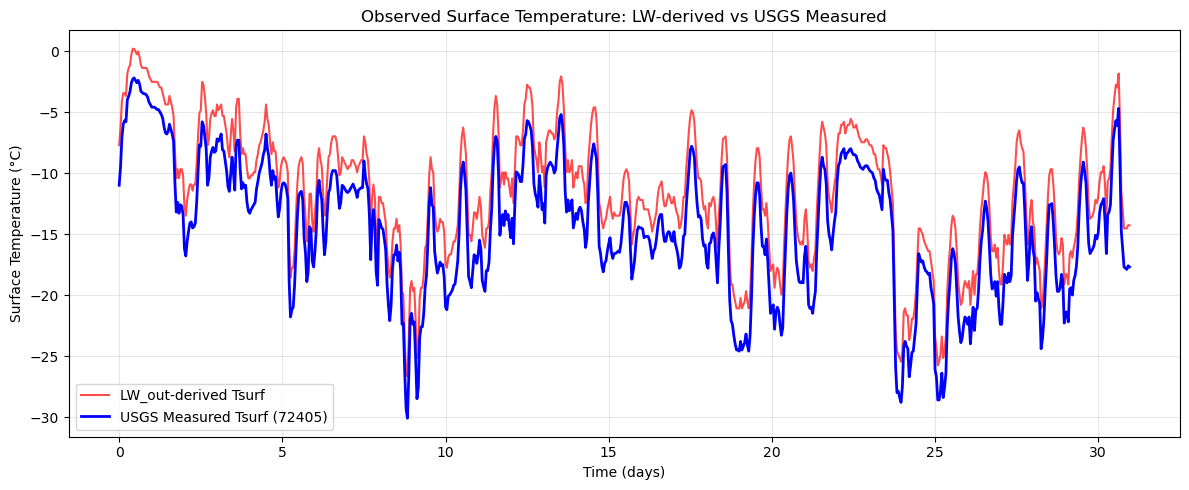

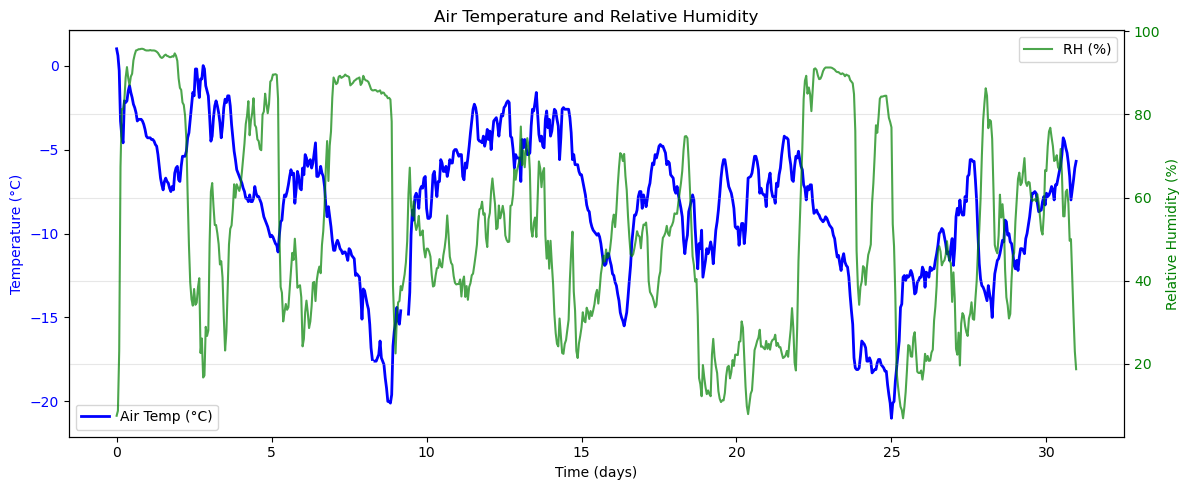

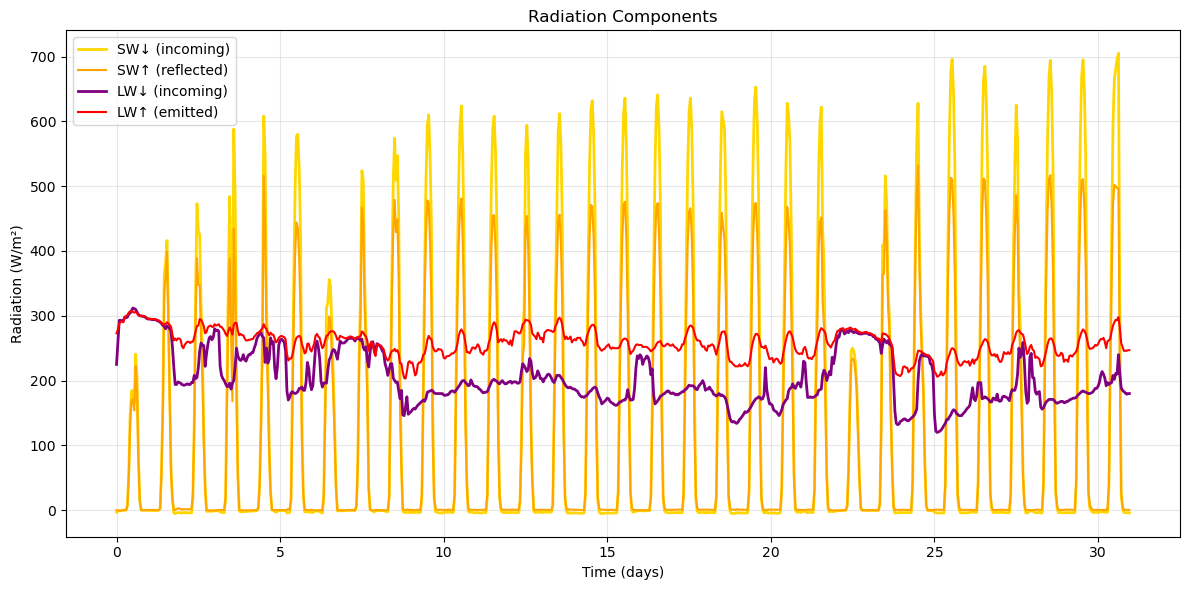

In [16]:
if show_plots:
    # Determine time axis (hours or days)
    max_time = times_arr.max()
    use_days = max_time > 72
    time_plot = times_arr / 24 if use_days else times_arr
    time_label = "Time (days)" if use_days else "Time (hours)"
    
    # Plot 1: Surface Temperature Comparison
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time_plot, lw_derived_surf_C, 'r-', alpha=0.7, label='LW_out-derived Tsurf')
    ax.plot(time_plot, df['surface_temp_c'].values, 'b-', linewidth=2, label='USGS Measured Tsurf (72405)')
    ax.set_xlabel(time_label)
    ax.set_ylabel("Surface Temperature (°C)")
    ax.set_title("Observed Surface Temperature: LW-derived vs USGS Measured")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Air Temperature and RH
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(time_plot, df['air_temp_c'].values, 'b-', linewidth=2, label='Air Temp (°C)')
    ax1.set_xlabel(time_label)
    ax1.set_ylabel("Temperature (°C)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='lower left')
    
    ax2 = ax1.twinx()
    ax2.plot(time_plot, df['rh_pct'].values, 'g-', alpha=0.7, label='RH (%)')
    ax2.set_ylabel("Relative Humidity (%)", color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend(loc='upper right')
    
    plt.title("Air Temperature and Relative Humidity")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Radiation Components
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time_plot, df['sw_down_wm2'].values, 'gold', linewidth=2, label='SW↓ (incoming)')
    ax.plot(time_plot, df['sw_up_wm2'].values, 'orange', linewidth=1.5, label='SW↑ (reflected)')
    ax.plot(time_plot, df['lw_down_wm2'].values, 'purple', linewidth=2, label='LW↓ (incoming)')
    ax.plot(time_plot, df['lw_up_wm2'].values, 'red', linewidth=1.5, label='LW↑ (emitted)')
    ax.set_xlabel(time_label)
    ax.set_ylabel("Radiation (W/m²)")
    ax.set_title("Radiation Components")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

## Snow Layer Construction

Divide the snowpack into N layers for numerical solution.

In [17]:
# Divides the snowpack into N layers
# Temperatures are stored at the midpoints of each layer (z_T)
# The faces of the layers are stored in z_F array

z_F = np.linspace(0.0, snow_depth_m, N+1)   # N+1 faces for N layers
z_T = 0.5*(z_F[:-1] + z_F[1:])              # Layer midpoints
dz  = z_F[1:] - z_F[:-1]                    # Thickness of each layer
H   = z_F[-1]                               # Should match snow_depth_m

print(f"Snow Depth = {H:.3f} m with {N} layers; each ~{dz[0]:.4f} m thick")

Snow Depth = 1.500 m with 35 layers; each ~0.0429 m thick


## Set Initial Temperature Profile

Create initial conditions using USGS surface temperature and assuming 0°C at ground.

In [18]:
T_ground = 273.15  # Ground temperature (0°C)
T_snow_min = df['surface_temp_c'].iloc[0] + 273.15  # Initial surface temp from USGS
H = snow_depth_m

# Define key points for PCHIP interpolation
x_key = np.array([0, 0.2, H - 0.2, H])
T_key = np.array([T_snow_min, (T_snow_min + T_ground) / 2.0, 
                  (T_snow_min + T_ground) / 2.0, T_ground])

# Create PCHIP interpolator
pchip = PchipInterpolator(x_key, T_key)

# Convert layer midpoints to distance from surface
x_vals = H - z_T

# Compute initial temperature profile
T_init = pchip(x_vals)
top_index = np.argmax(z_T)
T_init[top_index] = T_snow_min

print(f"Initial surface temperature: {T_snow_min - 273.15:.1f}°C")
print(f"Ground temperature: {T_ground - 273.15:.1f}°C")

Initial surface temperature: -11.0°C
Ground temperature: 0.0°C


## Physics Functions for Surface Energy Balance

Functions for atmospheric properties, radiative fluxes, and turbulent heat transfer.

In [19]:
def measured_air_temp(t_sec):
    # Return air temperature in Kelvin
    # Uses interpolated USGS data (already converted to K in T_air_interp)
    return T_air_interp(t_sec)

def get_wind_speed(t_sec):
    # Wind speed in m/s (already converted)
    return wind_interp(t_sec)

def compute_specific_humidity(T_C, RH, p=p_air):
    if T_C >= 0.0:
        e_sat = 611 * np.exp((17.27 * T_C) / (T_C + 237.3))
    else:
        e_sat = 611 * np.exp((22.46 * T_C) / (T_C + 272.62))
    e_act = RH * e_sat
    return (0.622 * e_act) / (p - (0.378 * e_act))

def get_air_specific_humidity(t_sec, p=p_air):
    T_airK = measured_air_temp(t_sec)
    T_airC = T_airK - 273.15
    RH_frac = RH_arr_interp(t_sec) / 100.0
    return compute_specific_humidity(T_airC, RH_frac, p)

def get_snow_specific_humidity(T_surfK, p=p_air):
    T_surfC = min(T_surfK - 273.15, 0.0)
    e_snow_sat = 611.0 * np.exp((22.46 * T_surfC) / (T_surfC + 272.62))
    return (0.622 * e_snow_sat) / (p - (0.378 * e_snow_sat))

def compute_atmospheric_emissivity(t_sec):
    # Brutsaert (1975) with cloud correction
    T_airK = measured_air_temp(t_sec)
    q_air = get_air_specific_humidity(t_sec)
    
    e_pa = q_air * p_air / (0.622 + 0.378 * q_air)
    e_hPa = e_pa / 100.0
    
    eps_atm = 1.24 * (e_hPa / T_airK)**(1.0/7.0)
    
    # Cloud correction based on RH
    rh_val = RH_arr_interp(t_sec)
    if rh_val > 50:
        factor = (rh_val - 50.0) / 50.0
        eps_atm += 0.06 * min(factor, 1.0)
    
    return np.clip(eps_atm, 0.5, 1.0)

def compute_shortwave_net(t_sec):
    sw_in_val = SW_in_interp(t_sec)
    sw_out_val = SW_out_interp(t_sec)
    
    if use_idealized_SWout:
        return sw_in_val * (1.0 - alpha_snow)
    else:
        return max(sw_in_val - sw_out_val, 0.0)

def turbulent_fluxes(t_sec, T_surfK):
    T_airK = measured_air_temp(t_sec)
    U = max(get_wind_speed(t_sec), 0.1)
    
    # Stability correction
    delta_T = T_airK - T_surfK
    if delta_T >= 0:
        stability_factor = 1.0
    else:
        stability_factor = min(1.0, max(0.5, (delta_T / 5)))
    
    Q_sensible = rho_air * c_pa * CH * U * (T_airK - T_surfK) * stability_factor
    
    q_air = get_air_specific_humidity(t_sec)
    q_snow = get_snow_specific_humidity(T_surfK)
    Q_latent = rho_air * Lv_subl * CE * U * (q_air - q_snow) * stability_factor
    
    return Q_sensible, Q_latent

def compute_radiative_fluxes(t_sec, T_surfK):
    lw_down = LW_in_interp(t_sec)
    lw_up = eps_snow * sigma * (T_surfK ** 4)
    lw_net = lw_down - lw_up
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def compute_idealized_radiative_fluxes(t_sec, T_surfK):
    T_airK = measured_air_temp(t_sec)
    eps_atm = compute_atmospheric_emissivity(t_sec)
    LW_in_ideal = eps_atm * sigma * (T_airK ** 4)
    lw_up = eps_snow * sigma * (T_surfK ** 4)
    lw_net = LW_in_ideal - lw_up
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def shortwave_absorption_twoBand(t_sec, z_faces):
    sw_net = compute_shortwave_net(t_sec)
    
    f_nir = 0.4
    f_vis = 1.0 - f_nir
    kappa_nir = 35.0
    kappa_vis = 5.0
    
    sw_nir_top = sw_net * f_nir
    sw_vis_top = sw_net * f_vis
    
    d_faces = H - z_faces
    d_top = d_faces[1:]
    d_bottom = d_faces[:-1]
    
    flux_in_nir = sw_nir_top * np.exp(-kappa_nir * d_top)
    flux_out_nir = sw_nir_top * np.exp(-kappa_nir * d_bottom)
    SW_abs_nir = flux_in_nir - flux_out_nir
    
    flux_in_vis = sw_vis_top * np.exp(-kappa_vis * d_top)
    flux_out_vis = sw_vis_top * np.exp(-kappa_vis * d_bottom)
    SW_abs_vis = flux_in_vis - flux_out_vis
    
    return np.maximum(SW_abs_nir + SW_abs_vis, 0.0)

def enforce_melt_freeze(T, dTdt, tau=1800):
    for i in range(len(T)):
        if T[i] > 273.15:
            latent_cooling_rate = (T[i] - 273.15) / tau
            dTdt[i] -= latent_cooling_rate
            if dTdt[i] > 0:
                dTdt[i] = 0
    return T, dTdt

## Main dT/dt Equation

The core ODE function for the temperature evolution of all snow layers.

In [20]:
def dT_dt(t_sec, T):
    F = np.zeros(N+1)
    
    # Ground flux
    F[0] = k * (T_ground - T[0]) / dz[0]
    for i in range(1, N):
        F[i] = k * (T[i-1] - T[i]) / dz[i]
    
    # Surface flux
    if use_idealized_LWin:
        net_radiative, _ = compute_idealized_radiative_fluxes(t_sec, T[-1])
    else:
        net_radiative, _ = compute_radiative_fluxes(t_sec, T[-1])
    
    Q_sensible, Q_latent = turbulent_fluxes(t_sec, T[-1])
    F[N] = -(net_radiative + Q_sensible + Q_latent)
    
    # Temperature tendency
    dTdt = np.zeros(N)
    for i in range(N):
        dTdt[i] = -(F[i+1] - F[i]) / (rho_snow * c_snow * dz[i])
    
    # Shortwave absorption
    if use_twoBand:
        SW_profile = shortwave_absorption_twoBand(t_sec, z_F)
    else:
        SW_profile = np.zeros(N)
    for i in range(N):
        dTdt[i] += SW_profile[i] / (rho_snow * c_snow * dz[i])
    
    # Melt/freeze
    T, dTdt = enforce_melt_freeze(T, dTdt, tau=1800)
    
    return dTdt

## Run Multiple SW/LW Scenarios

Compare 4 scenarios: measured vs idealized for both SW and LW.

Running scenarios...
  Measured SW out, Measured LW in...
  Measured SW out, Idealized LW in...
  Idealized SW out, Measured LW in...
  Idealized SW out, Idealized LW in...
Done!


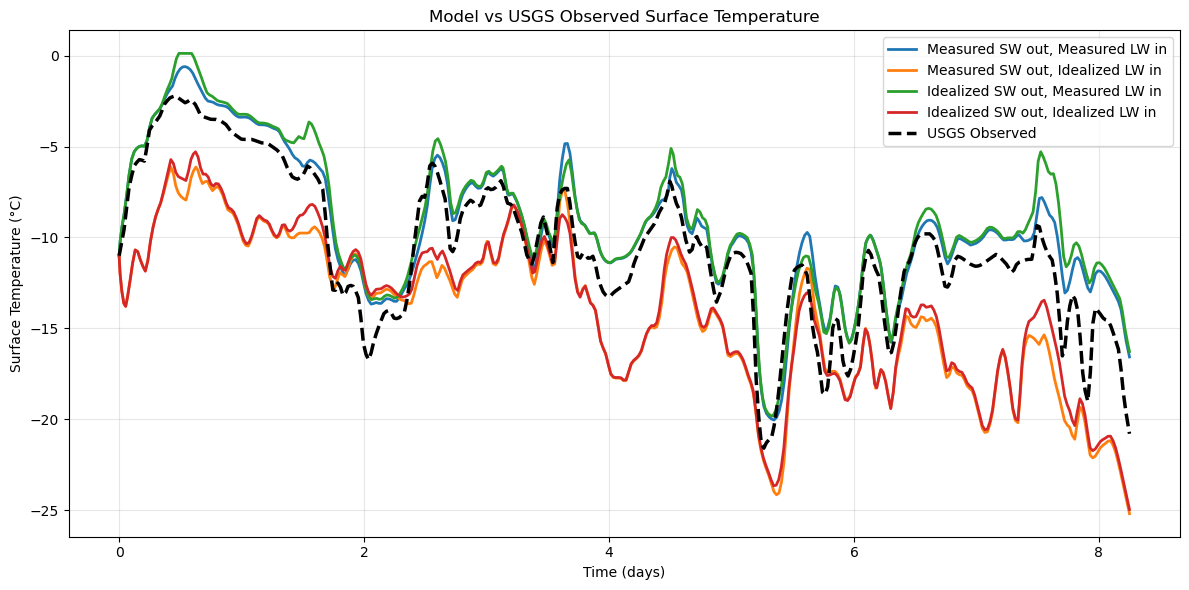

In [21]:
def run_snow_model(use_idealized_SW_local, use_idealized_LW_local):
    global use_idealized_SWout, use_idealized_LWin
    old_SW = use_idealized_SWout
    old_LW = use_idealized_LWin
    
    use_idealized_SWout = use_idealized_SW_local
    use_idealized_LWin = use_idealized_LW_local
    
    sol = solve_ivp(fun=dT_dt,
                    t_span=(0, t_end),
                    y0=T_init,
                    method='RK45',
                    max_step=dt_max,
                    rtol=1e-5,
                    atol=1e-7)
    
    use_idealized_SWout = old_SW
    use_idealized_LWin = old_LW
    
    # Calculate fluxes using the SAME scenario settings as the model run
    # This ensures diagnostic plots match what the solver actually used
    fluxes = {'net_radiative': [], 'sensible': [], 'latent': [], 'net_energy': []}
    for i, t_sec in enumerate(sol.t):
        T_surf = sol.y[-1, i]
        
        # Use the same LW setting that the solver used
        if use_idealized_LW_local:
            net_radiative, _ = compute_idealized_radiative_fluxes(t_sec, T_surf)
        else:
            net_radiative, _ = compute_radiative_fluxes(t_sec, T_surf)
        
        Q_sensible, Q_latent = turbulent_fluxes(t_sec, T_surf)
        fluxes['net_radiative'].append(net_radiative)
        fluxes['sensible'].append(Q_sensible)
        fluxes['latent'].append(Q_latent)
        fluxes['net_energy'].append(net_radiative + Q_sensible + Q_latent)
    
    return sol.t, sol.y, fluxes

# Define scenarios
scenarios = {
    "Measured SW out, Measured LW in":   (False, False),
    "Measured SW out, Idealized LW in":  (False, True),
    "Idealized SW out, Measured LW in":  (True,  False),
    "Idealized SW out, Idealized LW in": (True,  True)
}

results = {}

print("Running scenarios...")
for label, (sw_bool, lw_bool) in scenarios.items():
    print(f"  {label}...")
    t_run, T_layers_run, fluxes_run = run_snow_model(sw_bool, lw_bool)
    results[label] = {
        'time_sec': t_run,
        'T_layers': T_layers_run,
        'fluxes': fluxes_run
    }
print("Done!")

# Plot surface temperatures
plt.figure(figsize=(12, 6))
for label in scenarios:
    t_model = results[label]['time_sec']
    T_surf_C = results[label]['T_layers'][-1, :] - 273.15
    plt.plot(t_model/(3600*24), T_surf_C, label=label, linewidth=2)

# Add observed
some_t_sec = results["Measured SW out, Measured LW in"]['time_sec']
usgs_surf_C = usgs_temp_obs_interp(some_t_sec)
plt.plot(some_t_sec/(3600*24), usgs_surf_C, 'k--', linewidth=2.5, label='USGS Observed')

plt.xlabel("Time (days)")
plt.ylabel("Surface Temperature (°C)")
plt.title("Model vs USGS Observed Surface Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Error Analysis

Compare model output to USGS observed surface temperature.

ERROR ANALYSIS vs USGS MEASURED SURFACE TEMPERATURE

USGS Surface Temp (72405)
SCENARIO                               MAE   RMSE   BIAS   CORR  DAY Δ  NIGHT Δ
Measured SW out, Measured LW in       1.59   1.99   1.45  0.965   0.94     1.85
Measured SW out, Idealized LW in      3.83   4.30  -3.54  0.877  -3.33    -3.71
Idealized SW out, Measured LW in      1.82   2.24   1.74  0.957   1.46     1.97
Idealized SW out, Idealized LW in     3.56   4.03  -3.26  0.878  -2.88    -3.57

--- Plots use USGS measured surface temperature as reference ---


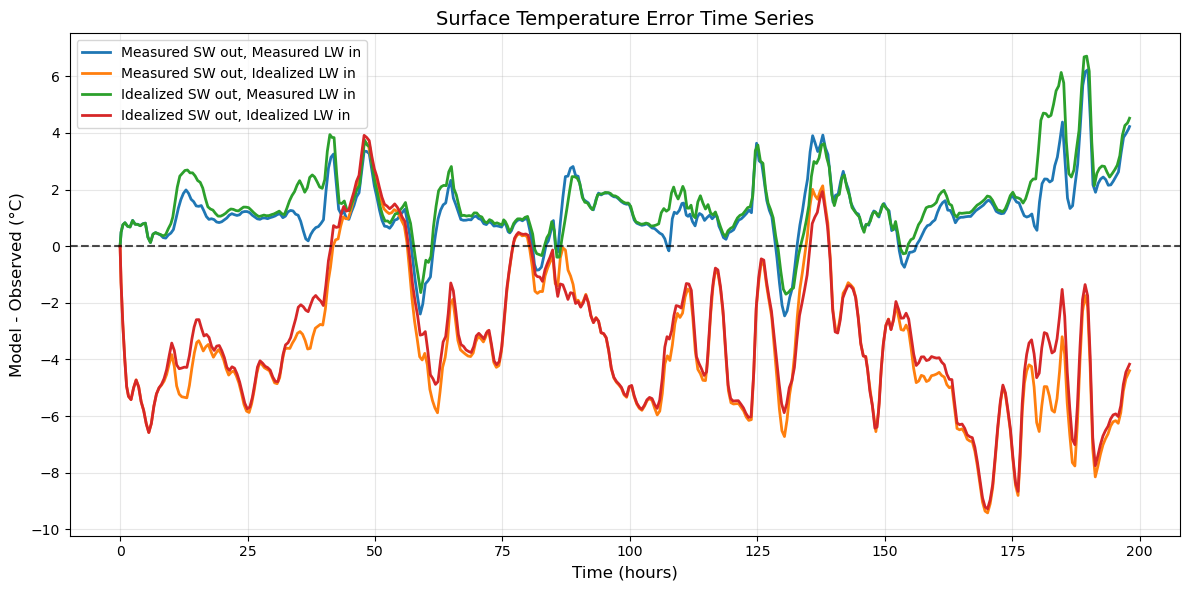

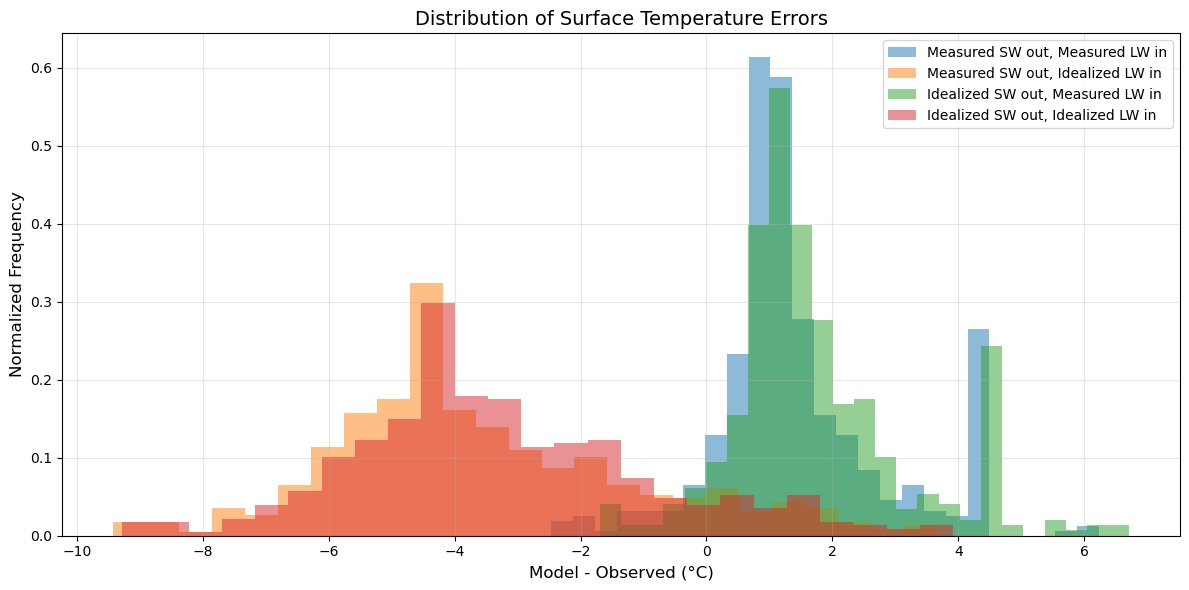

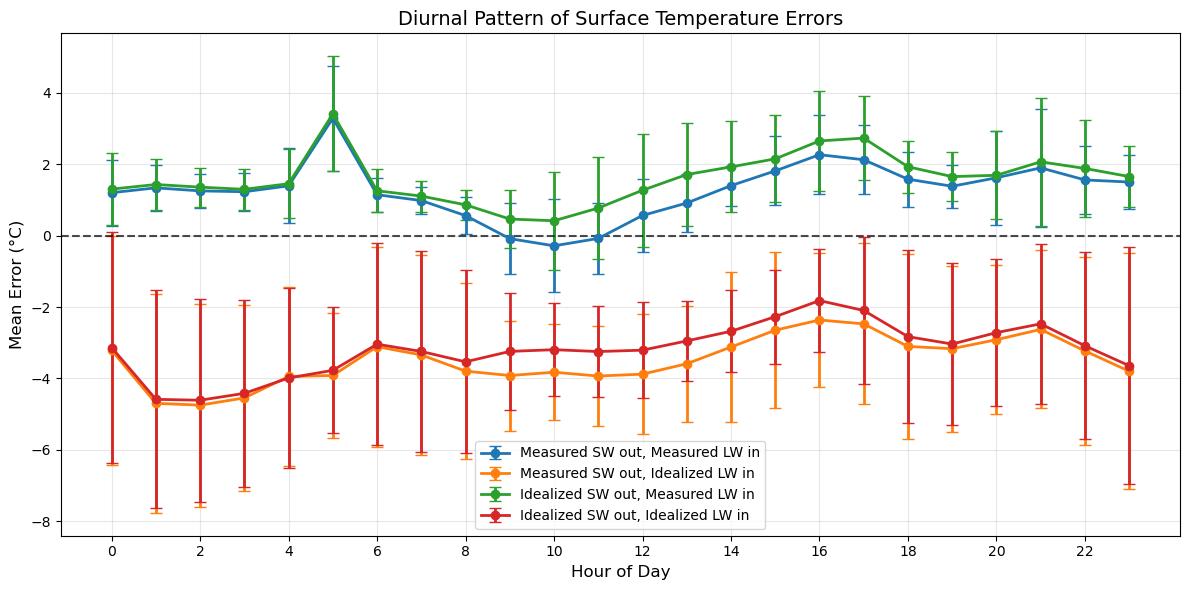

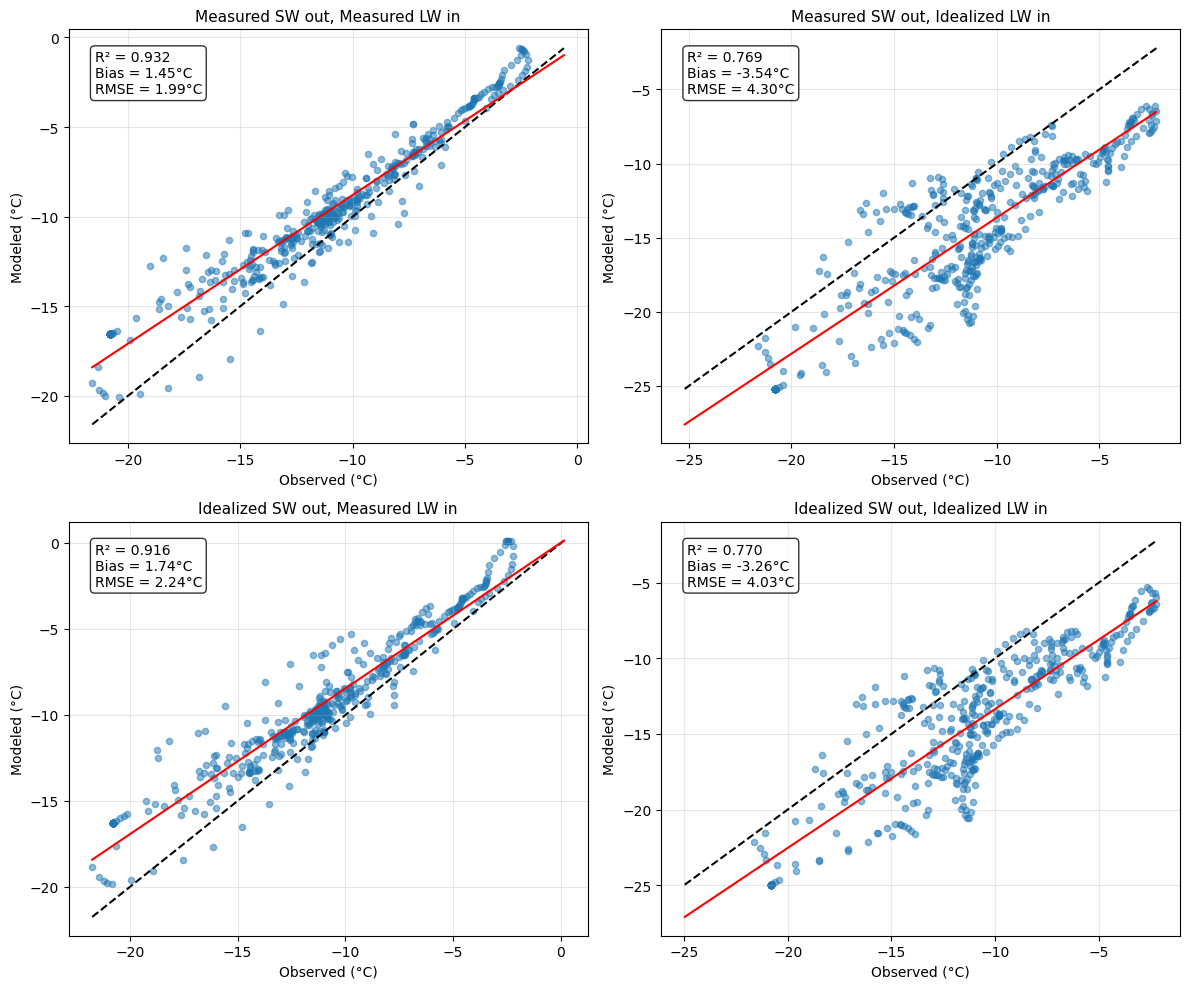

In [22]:
# =============================================================================
# ERROR ANALYSIS FUNCTIONS
# =============================================================================

def analyze_model_errors(results, observed_data_function):
    """Analyze model errors compared to observed surface temperature."""
    scenario_errors = {}
    scenario_stats = {}
    
    for label, data in results.items():
        t_model = data['time_sec']
        T_surf_C = data['T_layers'][-1, :] - 273.15
        obs_surf_tempC = observed_data_function(t_model)
        error = T_surf_C - obs_surf_tempC
        
        scenario_errors[label] = {
            'time_sec': t_model,
            'error': error,
            'observed': obs_surf_tempC,
            'modeled': T_surf_C
        }
        
        mae = np.mean(np.abs(error))
        rmse = np.sqrt(np.mean(error**2))
        bias = np.mean(error)
        correlation = np.corrcoef(obs_surf_tempC, T_surf_C)[0, 1]
        
        hours = [(t % (24*3600))/3600 for t in t_model]
        day_mask = np.array([(6 <= h <= 18) for h in hours])
        night_mask = ~day_mask
        
        day_bias = np.mean(error[day_mask]) if np.any(day_mask) else np.nan
        night_bias = np.mean(error[night_mask]) if np.any(night_mask) else np.nan
        
        scenario_stats[label] = {
            'MAE': mae, 'RMSE': rmse, 'Bias': bias,
            'Correlation': correlation, 'Day Bias': day_bias, 'Night Bias': night_bias
        }
    
    return scenario_errors, scenario_stats

def plot_error_timeseries(scenario_errors):
    """Plot time series of errors for each scenario."""
    plt.figure(figsize=(12, 6))
    for label, data in scenario_errors.items():
        time_hrs = data['time_sec'] / 3600.0
        plt.plot(time_hrs, data['error'], label=label, linewidth=2)
    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel("Time (hours)", fontsize=12)
    plt.ylabel("Model - Observed (°C)", fontsize=12)
    plt.title("Surface Temperature Error Time Series", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

def plot_error_histogram(scenario_errors):
    """Plot histogram of errors for each scenario."""
    plt.figure(figsize=(12, 6))
    for label, data in scenario_errors.items():
        plt.hist(data['error'], bins=25, alpha=0.5, label=label, density=True)
    plt.xlabel("Model - Observed (°C)", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.title("Distribution of Surface Temperature Errors", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

def plot_diurnal_errors(scenario_errors):
    """Plot errors by hour of day to visualize diurnal patterns."""
    plt.figure(figsize=(12, 6))
    for label, data in scenario_errors.items():
        times = data['time_sec']
        hours = [(t % (24*3600))/3600 for t in times]
        error = data['error']
        
        hour_bins = np.arange(25)
        hour_indices = np.digitize(hours, hour_bins) - 1
        hourly_errors = [[] for _ in range(24)]
        
        for h_idx, err in zip(hour_indices, error):
            if 0 <= h_idx < 24:
                hourly_errors[h_idx].append(err)
        
        hour_means = [np.mean(errs) if errs else np.nan for errs in hourly_errors]
        hour_stds = [np.std(errs) if len(errs) > 1 else 0 for errs in hourly_errors]
        
        plt.errorbar(np.arange(24), hour_means, yerr=hour_stds, 
                    label=label, fmt='o-', capsize=4, linewidth=2)
    
    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Mean Error (°C)", fontsize=12)
    plt.title("Diurnal Pattern of Surface Temperature Errors", fontsize=14)
    plt.xticks(np.arange(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

def plot_scatter_comparison(scenario_errors):
    """Create scatter plot of observed vs modeled temperatures."""
    plt.figure(figsize=(12, 10))
    for i, (label, data) in enumerate(scenario_errors.items()):
        plt.subplot(2, 2, i+1)
        observed = data['observed']
        modeled = data['modeled']
        
        plt.scatter(observed, modeled, alpha=0.5, s=20)
        
        min_val = min(np.min(observed), np.min(modeled))
        max_val = max(np.max(observed), np.max(modeled))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1')
        
        z = np.polyfit(observed, modeled, 1)
        p = np.poly1d(z)
        plt.plot([min_val, max_val], p([min_val, max_val]), 'r-', label='Fit')
        
        r2 = np.corrcoef(observed, modeled)[0, 1]**2
        bias = np.mean(modeled - observed)
        rmse = np.sqrt(np.mean((modeled - observed)**2))
        plt.text(0.05, 0.95, f"R² = {r2:.3f}\nBias = {bias:.2f}°C\nRMSE = {rmse:.2f}°C", 
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.title(label, fontsize=11)
        plt.xlabel("Observed (°C)")
        plt.ylabel("Modeled (°C)")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt.gcf()

def display_error_stats_table(scenario_stats, title=""):
    """Display a formatted table of error statistics."""
    if title:
        print(f"\n{title}")
    header = f"{'SCENARIO':<35} {'MAE':>6} {'RMSE':>6} {'BIAS':>6} {'CORR':>6} {'DAY Δ':>6} {'NIGHT Δ':>8}"
    separator = "=" * len(header)
    print(header)
    print(separator)
    for label, stats in scenario_stats.items():
        print(f"{label:<35} {stats['MAE']:6.2f} {stats['RMSE']:6.2f} {stats['Bias']:6.2f} "
              f"{stats['Correlation']:6.3f} {stats['Day Bias']:6.2f} {stats['Night Bias']:8.2f}")
    print(separator)

# =============================================================================
# RUN ERROR ANALYSIS
# =============================================================================

# PRIMARY: Compare against USGS measured surface temperature (72405)
print("=" * 70)
print("ERROR ANALYSIS vs USGS MEASURED SURFACE TEMPERATURE")
print("=" * 70)
scenario_errors_usgs, scenario_stats_usgs = analyze_model_errors(results, usgs_temp_obs_interp)
display_error_stats_table(scenario_stats_usgs, "USGS Surface Temp (72405)")

# Plot error visualizations (using USGS as primary)
print("\n--- Plots use USGS measured surface temperature as reference ---")
plot_error_timeseries(scenario_errors_usgs)
plt.show()

plot_error_histogram(scenario_errors_usgs)
plt.show()

plot_diurnal_errors(scenario_errors_usgs)
plt.show()

plot_scatter_comparison(scenario_errors_usgs)
plt.show()

## Animation: Temperature Profile Evolution

Generate animated GIF of temperature profiles for all scenarios.

In [23]:
if generate_animation:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    lines = []
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, (label, _) in enumerate(scenarios.items()):
        line, = ax.plot([], [], '-o', color=colors[i], label=label, markersize=3)
        lines.append(line)
    
    first_scenario = list(results.values())[0]
    time = first_scenario['time_sec']
    
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                       bbox=dict(facecolor='white', alpha=0.7))
    
    def init_anim():
        ax.set_xlim(-30, 2)
        ax.set_ylim(-0.25, H + 0.5)
        ax.set_xlabel("Temperature (°C)")
        ax.set_ylabel("Depth (m)")
        ax.set_title("Snow Temperature Profile Evolution")
        ax.grid(True, alpha=0.3)
        ax.axhspan(-0.25, 0, color='brown', alpha=0.3)
        ax.axhspan(H, H + 0.5, color='skyblue', alpha=0.2)
        ax.legend(loc='upper right')
        return lines + [time_text]
    
    def animate(frame):
        total_frames = 50
        idx = min(int(frame * len(time) / total_frames), len(time) - 1)
        hrs = time[idx] / 3600
        
        time_text.set_text(f'Time: {hrs:.1f} h ({hrs/24:.1f} days)')
        
        for j, (label, _) in enumerate(scenarios.items()):
            T_layers = results[label]['T_layers']
            if idx < T_layers.shape[1]:
                T_s = T_layers[:, idx] - 273.15
                lines[j].set_data(T_s, z_T)
        
        return lines + [time_text]
    
    try:
        ani = FuncAnimation(fig, animate, frames=50,
                          init_func=init_anim, interval=100, blit=True)
        ani.save('../figures/snowmodel_USGS_animation.gif', writer='pillow', fps=5)
        plt.close()
        display(Image('../figures/snowmodel_USGS_animation.gif'))
    except Exception as e:
        print(f"Error creating animation: {e}")
        plt.close()
else:
    print("Animation generation skipped.")

Animation generation skipped.
